Importing all the libaries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import requests

Scrape a CSV file from the spreadsheet

In [ ]:
# get csv from to df https://docs.google.com/spreadsheets/d/1ZafspjnRJuDjLRKotQ8awLTGcf3RLxrBEh2JtqRGh0Y/edit?usp=sharing
df1 = pd.read_csv('https://docs.google.com/spreadsheets/d/1ZafspjnRJuDjLRKotQ8awLTGcf3RLxrBEh2JtqRGh0Y/export?format=csv')
# get csv from https://docs.google.com/spreadsheets/d/1A-6z5Fe30C266rK-6TnQm6CNOGCOnjK6s4hwfRIDMhQ/edit?usp=sharing to df
df2 = pd.read_csv('https://docs.google.com/spreadsheets/d/1A-6z5Fe30C266rK-6TnQm6CNOGCOnjK6s4hwfRIDMhQ/export?format=csv')
# combine df1 and df2
df = pd.concat([df1, df2], axis=0)

df.head()

Clean Data

In [ ]:
# Let's remove all the columns that we don't need
df = df.drop(columns=['Discord', 'Other', 'Date Accepted']).reset_index(drop=True)
# delete all duplicate rows
df = df.drop_duplicates(keep='first')
# Remove all the '%" in the average column
df['Average'] = df['Average'].str.replace('%', '')
df['Average'] = df['Average'].str.replace('~', '')
df['Average'] = df['Average'].str.replace(',', '')
# remove all + in the average column
df['Average'] = df['Average'].str.replace('+', '')
# Delete rows where average  NaN
df = df.dropna(how = 'any', subset=['Average'])

blacklisted_avgs = {'99.75 (gr.12 data, adv func, bio, chem)': '99.75',
                    'Top6 98, 5 in AP CS and 7 in both IB Math and Physics': '98',
                    '96ish': '96.5',
                    '94-95': '94.5',
                    '98.5-99ish': '98.5',
                    'sub 90’s': '97.5',
                    '4.0/4.66': '98',
                    '96.6 g11': '96.3',
                    '94.7 gr12 sem 1 96.6 gr11': '96.3',
                    'probably 97.5': '97.5',
                    '39/42(IB)': '97',
                    '97-98ish': '97.5',
                    '99 (based on g11 final and g12 midterm, not likely to maintain)' : '99',
                    '99.75 (gr.12 data adv func bio chem)': '99.75',
                    'Top6 98 5 in AP CS and 7 in both IB Math and Physics': '98',
                    'sub 90’s or somethin': '97.5',
                    'around 95 idk what they look at': '95',
                    '99 (based on g11 final and g12 midterm not likely to maintain)': '99',
                    'around 95 idk': '95',
                    }

# make sure that if the data frame has value that is a key of the dictionary, it will be replaced with the value
for i in range(10):
    df['Average'] = df['Average'].replace(blacklisted_avgs)


UTSG CS

In [ ]:
# Get all utsg
# refactored by @khyreek #####################################################

# get df where utsg is there
df_utsg = pd.concat([
    df[df['School'].str.contains(uoft, na=False, case=False)]
    for uoft in ('UTSG', 'Toronto', 'UOFT', 'U of T')
])

# Get all cs within utsg not case sensitive
df_utsg_cs = pd.concat([
    df_utsg[df_utsg['Program'].str.contains(cs_variant, na=False, case=False)]
    for cs_variant in ('Computer Science', 'CS', 'comp sci')
])

for pair in (('School', 'Scarborough'), ('Program', 'Math')):
    # drop all rows where school has scarbgrough in the name
    # drop all rows where program has math in the name

    row, sub_data = pair
    df_utsg_cs = (
        df_utsg_cs[~df_utsg_cs[row]
            .str
            .contains(sub_data, na=False, case=False)]
    )

# get all accepted
df_utsg_cs_accepted = df_utsg_cs[df_utsg_cs['Status'] == 'Accepted']
df_utsg_cs_accepted101 = df_utsg_cs_accepted[df_utsg_cs_accepted['Type (101/105)'] == '101']
df_utsg_cs_accepted105 = df_utsg_cs_accepted[df_utsg_cs_accepted['Type (101/105)'].str.contains('105')]

for accepted in (df_utsg_cs_accepted, df_utsg_cs_accepted101, df_utsg_cs_accepted105):
    # get average of df_utsg_cs_accepted average column

    accepted = accepted.reset_index(drop=True)
    accepted['Average'] = accepted['Average'].astype(float)

for uoft_admits, message_prefix in zip(
        (df_utsg_cs_accepted, df_utsg_cs_accepted101, df_utsg_cs_accepted105), 
        ("Admission Average:", "Admission Average 101:", "Admission Average 105:")):

    print(f"{message_prefix} {df_utsg_cs_accepted['Average'].mean()}")

In [ ]:
plt.title("University of Toronto\nComputer Science Admission Averages")
plt.xlabel("Grades")
plt.ylabel("Number of People")
plt.hist(np.array(df_utsg_cs_accepted["Average"].tolist(), dtype=np.float64))
plt.show()

Waterloo Software Engineering

In [ ]:
df_uw1 = df[df['School'].str.contains('UW', na=False, case=False)]
df_uw2 = df[df['School'].str.contains('University of Waterloo', na=False, case=False)]
df_uw3 = df[df['School'].str.contains('Waterloo', na=False, case=False)]

df_uw = pd.concat([df_uw1, df_uw2, df_uw3])

df_uw_se1 = df_uw[df_uw['Program'].str.contains('Software Engineering', na=False, case=False)]
df_uw_se2 = df_uw[df_uw['Program'].str.contains('SE', na=False, case=False)]
df_uw_se3 = df_uw[df_uw['Program'].str.contains('software eng', na=False, case=False)]
df_uw_se4 = df_uw[df_uw['Program'].str.contains('soft eng', na=False, case=False)]

df_uw_se = pd.concat([df_uw_se1, df_uw_se2, df_uw_se3]).reset_index(drop=True)

# get all the accepted
df_uw_se_accepted = df_uw_se[df_uw_se['Status'] == 'Accepted'].reset_index(drop=True)
df_uw_se_accepted101 = df_uw_se_accepted[df_uw_se_accepted['Type (101/105)'] == '101'].reset_index(drop=True)
df_uw_se_accepted105 = df_uw_se_accepted[df_uw_se_accepted['Type (101/105)'].str.contains('105')].reset_index(drop=True)

# get the averages
df_uw_se_accepted['Average'] = df_uw_se_accepted['Average'].astype(float)
df_uw_se_accepted105['Average'] = df_uw_se_accepted105['Average'].astype(float)
df_uw_se_accepted101['Average'] = df_uw_se_accepted101['Average'].astype(float)

# print the averages
print("Admission Average: " + str(df_uw_se_accepted['Average'].mean()))
print("Admission Average 101: " + str(df_uw_se_accepted101['Average'].mean()))
print("Admission Average 105: " + str(df_uw_se_accepted105['Average'].mean()))



In [ ]:
plt.title("University of Waterloo\nSoftware Engineering Admission Averages")
plt.xlabel("Grades")
plt.ylabel("Number of People")
plt.hist(np.array(df_uw_se_accepted["Average"].tolist(), dtype=np.float64))
plt.show()

Waterloo Computer Engineering

In [ ]:
df_uw_ce1 = df_uw[df_uw['Program'].str.contains('Computer Engineering', na=False, case=False)]
df_uw_ce2 = df_uw[df_uw['Program'] == 'CE']
df_uw_ce5 = df_uw[df_uw['Program'] == 'ce']
df_uw_ce3 = df_uw[df_uw['Program'].str.contains('computer eng', na=False, case=False)]
df_uw_ce4 = df_uw[df_uw['Program'].str.contains('comp eng', na=False, case=False)]

df_uw_ce = pd.concat([df_uw_ce1, df_uw_ce2, df_uw_ce3, df_uw_ce4, df_uw_ce5]).reset_index(drop=True)

#get all accepted
df_uw_ce_accepted = df_uw_ce[df_uw_ce['Status'] == 'Accepted'].reset_index(drop=True)
df_uw_ce_accepted101 = df_uw_ce_accepted[df_uw_ce_accepted['Type (101/105)'] == '101'].reset_index(drop=True)
df_uw_ce_accepted105 = df_uw_ce_accepted[df_uw_ce_accepted['Type (101/105)'].str.contains('105')].reset_index(drop=True)

#get the averages
df_uw_ce_accepted['Average'] = df_uw_ce_accepted['Average'].astype(float)
df_uw_ce_accepted105['Average'] = df_uw_ce_accepted105['Average'].astype(float)
df_uw_ce_accepted101['Average'] = df_uw_ce_accepted101['Average'].astype(float)

# print the averages
print("Admission Average: " + str(df_uw_ce_accepted['Average'].mean()))
print("Admission Average 101: " + str(df_uw_ce_accepted101['Average'].mean()))
print("Admission Average 105: " + str(df_uw_ce_accepted105['Average'].mean()))



In [ ]:
plt.title("University of Waterloo\nComputer Engineering Admission Averages")
plt.xlabel("Grades")
plt.ylabel("Number of People")
plt.hist(np.array(df_uw_ce_accepted["Average"].tolist(), dtype=np.float64))
plt.show()

UW Tron

In [ ]:
df_uw_tron1 = df_uw[df_uw['Program'].str.contains('Tron', na=False, case=False)]
df_uw_tron2 = df_uw[df_uw['Program'].str.contains('Mechatronics', na=False, case=False)]

# combine
df_uw_tron = pd.concat([df_uw_tron1, df_uw_tron2]).reset_index(drop=True)

# get accepted
df_uw_tron_accepted = df_uw_tron[df_uw_tron['Status'] == 'Accepted'].reset_index(drop=True)
df_uw_tron_accepted101 = df_uw_tron_accepted[df_uw_tron_accepted['Type (101/105)'] == '101'].reset_index(drop=True)
df_uw_tron_accepted105 = df_uw_tron_accepted[df_uw_tron_accepted['Type (101/105)'].str.contains('105')].reset_index(drop=True)

# get averages
df_uw_tron_accepted['Average'] = df_uw_tron_accepted['Average'].astype(float)
df_uw_tron_accepted105['Average'] = df_uw_tron_accepted105['Average'].astype(float)
df_uw_tron_accepted101['Average'] = df_uw_tron_accepted101['Average'].astype(float)

# print averages
print("Admission Average: " + str(df_uw_tron_accepted['Average'].mean()))
print("Admission Average 101: " + str(df_uw_tron_accepted101['Average'].mean()))
print("Admission Average 105: " + str(df_uw_tron_accepted105['Average'].mean()))




In [ ]:
plt.title("University of Waterloo\nMechatronics Engineering Admission Averages")
plt.xlabel("Grades")
plt.ylabel("Number of People")
plt.hist(np.array(df_uw_tron_accepted["Average"].tolist(), dtype=np.float64))
plt.show()

UW MGMNT

In [ ]:
df_uw_mgmnt = df_uw[df_uw['Program'].str.contains('Management Eng', na=False, case=False)]

df_uw_mgmnt_accepted = df_uw_mgmnt[df_uw_mgmnt['Status'] == 'Accepted'].reset_index(drop=True)
df_uw_mgmnt_accepted101 = df_uw_mgmnt_accepted[df_uw_mgmnt_accepted['Type (101/105)'] == '101'].reset_index(drop=True)
df_uw_mgmnt_accepted105 = df_uw_mgmnt_accepted[df_uw_mgmnt_accepted['Type (101/105)'].str.contains('105')].reset_index(drop=True)

#get the averages
df_uw_mgmnt_accepted['Average'] = df_uw_mgmnt_accepted['Average'].astype(float)
df_uw_mgmnt_accepted105['Average'] = df_uw_mgmnt_accepted105['Average'].astype(float)
df_uw_mgmnt_accepted101['Average'] = df_uw_mgmnt_accepted101['Average'].astype(float)

#print the averages
print("Admission Average: " + str(df_uw_mgmnt_accepted['Average'].mean()))
print("Admission Average 101: " + str(df_uw_mgmnt_accepted101['Average'].mean()))
print("Admission Average 105: " + str(df_uw_mgmnt_accepted105['Average'].mean()))


In [ ]:
plt.title("University of Waterloo\nManagement Engineering Admission Averages")
plt.xlabel("Grades")
plt.ylabel("Number of People")
plt.hist(np.array(df_uw_mgmnt_accepted["Average"].tolist(), dtype=np.float64))
plt.show()

UOFT Eng Sci

In [ ]:
df_utsg_engsci1 = df_utsg[df_utsg['Program'].str.contains('Engineering Science', na=False, case=False)]
df_utsg_engsci2 = df_utsg[df_utsg['Program'].str.contains('EngSci', na=False, case=False)]
df_utsg_engsci3 = df_utsg[df_utsg['Program'].str.contains('Eng sci', na=False, case=False)]

#combine
df_utsg_engsci = pd.concat([df_utsg_engsci1, df_utsg_engsci2, df_utsg_engsci3]).reset_index(drop=True)

# get accepted
df_utsg_engsci_accepted = df_utsg_engsci[df_utsg_engsci['Status'] == 'Accepted'].reset_index(drop=True)
df_utsg_engsci_accepted101 = df_utsg_engsci_accepted[df_utsg_engsci_accepted['Type (101/105)'] == '101'].reset_index(drop=True)
df_utsg_engsci_accepted105 = df_utsg_engsci_accepted[df_utsg_engsci_accepted['Type (101/105)'].str.contains('105')].reset_index(drop=True)

# get average of 101
df_utsg_engsci_accepted['Average'] = df_utsg_engsci_accepted['Average'].astype(float)
df_utsg_engsci_accepted101['Average'] = df_utsg_engsci_accepted101['Average'].astype(float)
df_utsg_engsci_accepted105['Average'] = df_utsg_engsci_accepted105['Average'].astype(float)

# print averages
print("Admission Average: " + str(df_utsg_engsci_accepted['Average'].mean()))
print("Admission Average 101: " + str(df_utsg_engsci_accepted101['Average'].mean()))
print("Admission Average 105: " + str(df_utsg_engsci_accepted105['Average'].mean()))




In [ ]:
plt.title("University of Toronto\nEngineering Science Admission Averages")
plt.xlabel("Grades")
plt.ylabel("Number of People")
plt.hist(np.array(df_utsg_engsci_accepted["Average"].tolist(), dtype=np.float64))
plt.show()

UOttawa CS

In [ ]:
df_uottawa = df[df['School'].str.contains('ottawa', na=False, case=False)]

df_uottawa_cs1 = df_uottawa[df_uottawa['Program'].str.contains('CS', na=False, case=False)]
df_uottawa_cs2 = df_uottawa[df_uottawa['Program'].str.contains('Computer Science', na=False, case=False)]
df_uottawa_cs3 = df_uottawa[df_uottawa['Program'].str.contains('comp sci', na=False, case=False)]

# combine them
df_uottawa_cs = pd.concat([df_uottawa_cs1, df_uottawa_cs2, df_uottawa_cs3]).reset_index(drop=True)

# get accepted
df_uottawa_cs_accepted = df_uottawa_cs[df_uottawa_cs['Status'] == 'Accepted'].reset_index(drop=True)
df_uottawa_cs_accepted101 = df_uottawa_cs_accepted[df_uottawa_cs_accepted['Type (101/105)'] == '101'].reset_index(drop=True)
# df_uottawa_cs_accepted105 = df_uottawa_cs_accepted[df_uottawa_cs_accepted['Type (101/105)'].str.contains('105')].reset_index(drop=True)

#get averages
df_uottawa_cs_accepted['Average'] = df_uottawa_cs_accepted['Average'].astype(float)
df_uottawa_cs_accepted101['Average'] = df_uottawa_cs_accepted101['Average'].astype(float)
# df_uottawa_cs_accepted105['Average'] = df_uottawa_cs_accepted105['Average'].astype(float)

#print averages
print("Admission Average: " + str(df_uottawa_cs_accepted['Average'].mean()))
print("Admission Average 101: " + str(df_uottawa_cs_accepted101['Average'].mean()))
# get the min 
print("Lowest Avg 105: " + str(df_uottawa_cs_accepted['Average'].min()))
print("Lowest Average 101: " + str(df_uottawa_cs_accepted101['Average'].min()))


In [ ]:
plt.title("University of Ottawa\nComputer Science Admission Averages")
plt.xlabel("Grades")
plt.ylabel("Number of People")
plt.hist(np.array(df_uottawa_cs_accepted["Average"].tolist(), dtype=np.float64))
plt.show()

Waterloo Engineering


In [ ]:
df_uw_eng1 = df_uw[df_uw['Program'].str.contains('Engineering', na=False, case=False)]
df_uw_eng2 = df_uw[df_uw['Program'].str.contains('Eng', na=False, case=False)]

# combine
df_uw_eng = pd.concat([df_uw_eng1, df_uw_eng2]).reset_index(drop=True)

# get accepted
df_uw_eng_accepted = df_uw_eng[df_uw_eng['Status'] == 'Accepted'].reset_index(drop=True)
df_uw_eng_accepted101 = df_uw_eng_accepted[df_uw_eng_accepted['Type (101/105)'] == '101'].reset_index(drop=True)
df_uw_eng_accepted105 = df_uw_eng_accepted[df_uw_eng_accepted['Type (101/105)'].str.contains('105')].reset_index(drop=True)

# get avvg
df_uw_eng_accepted['Average'] = df_uw_eng_accepted['Average'].astype(float)
df_uw_eng_accepted101['Average'] = df_uw_eng_accepted101['Average'].astype(float)
df_uw_eng_accepted105['Average'] = df_uw_eng_accepted105['Average'].astype(float)

# print averages 
print("Admission Average: " + str(df_uw_eng_accepted['Average'].mean()))
print("Admission Average 101: " + str(df_uw_eng_accepted101['Average'].mean()))
print("Admission Average 105: " + str(df_uw_eng_accepted105['Average'].mean()))


In [ ]:
plt.title("University of Waterloo\nEngineering Admission Averages")
plt.xlabel("Grades")
plt.ylabel("Number of People")
plt.hist(np.array(df_uw_eng_accepted["Average"].tolist(), dtype=np.float64))
plt.show()

Western Ivey

In [ ]:
df_ivey = df[df['Program'].str.contains('ivey', na=False, case=False)]

# get accepted
df_ivey_accepted = df_ivey[df_ivey['Status'] == 'Accepted'].reset_index(drop=True)
df_ivey_accepted101 = df_ivey_accepted[df_ivey_accepted['Type (101/105)'] == '101'].reset_index(drop=True)
df_ivey_accepted105 = df_ivey_accepted[df_ivey_accepted['Type (101/105)'].str.contains('105')].reset_index(drop=True)

# get avg
df_ivey_accepted['Average'] = df_ivey_accepted['Average'].astype(float)
df_ivey_accepted101['Average'] = df_ivey_accepted101['Average'].astype(float)
df_ivey_accepted105['Average'] = df_ivey_accepted105['Average'].astype(float)

# print averages
print("Admission Average: " + str(df_ivey_accepted['Average'].mean()))
print("Admission Average 101: " + str(df_ivey_accepted101['Average'].mean()))
print("Admission Average 105: " + str(df_ivey_accepted105['Average'].mean()))

In [ ]:
plt.title("Western University\nIvey Business School Admission Averages")
plt.xlabel("Grades")
plt.ylabel("Number of People")
plt.hist(np.array(df_ivey_accepted["Average"].tolist(), dtype=np.float64))
plt.show()

Queens Computing


In [ ]:
df_queens1 = df[df['School'].str.contains("Queen's", na=False, case=False)]
df_queens2 = df[df['School'].str.contains("queens", na=False, case=False)]

#combine
df_queens = pd.concat([df_queens1, df_queens2]).reset_index(drop=True)

df_queens_cs1 = df_queens[df_queens['Program'].str.contains('Computer Science', na=False, case=False)]
df_queens_cs2 = df_queens[df_queens['Program'].str.contains('CS', na=False, case=False)]
df_queens_cs3 = df_queens[df_queens['Program'].str.contains('comp sci', na=False, case=False)]
df_queens_cs4 = df_queens[df_queens['Program'].str.contains('Computing', case=False)]

# combine
df_queens_cs = pd.concat([df_queens_cs1, df_queens_cs2, df_queens_cs3, df_queens_cs4]).reset_index(drop=True)

# get accepted
df_queens_cs_accepted = df_queens_cs[df_queens_cs['Status'] == 'Accepted'].reset_index(drop=True)
df_queens_cs_accepted101 = df_queens_cs_accepted[df_queens_cs_accepted['Type (101/105)'] == '101'].reset_index(drop=True)
df_queens_cs_accepted105 = df_queens_cs_accepted[df_queens_cs_accepted['Type (101/105)'].str.contains('105')].reset_index(drop=True)

# get avg
df_queens_cs_accepted['Average'] = df_queens_cs_accepted['Average'].astype(float)
df_queens_cs_accepted101['Average'] = df_queens_cs_accepted101['Average'].astype(float)
df_queens_cs_accepted105['Average'] = df_queens_cs_accepted105['Average'].astype(float)

# print averages
print("Admission Average: " + str(df_queens_cs_accepted['Average'].mean()))
print("Admission Average 101: " + str(df_queens_cs_accepted101['Average'].mean()))
print("Admission Average 105: " + str(df_queens_cs_accepted105['Average'].mean()))


In [ ]:
plt.title("Queen's University\nComputing Admission Averages")
plt.xlabel("Grades")
plt.ylabel("Number of People")
plt.hist(np.array(df_queens_cs_accepted["Average"].tolist(), dtype=np.float64))
plt.show()

get stats on user input


Admission Average: 98.69166666666666
Admission Average 101: 98.69166666666666
Admission Average 105: nan


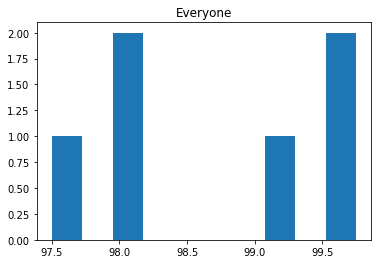

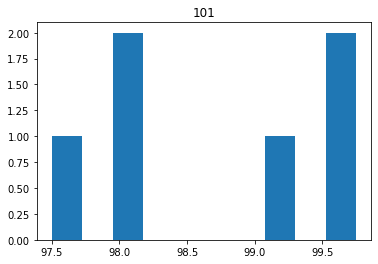

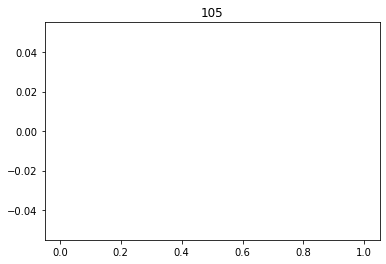

In [270]:
def getDF(uni_names = [],program_names = []):
    df_uni_stats = pd.DataFrame()
    df_program_stats = pd.DataFrame()
    for i in range(len(uni_names)):
        # append this to a df df[df['School'].str.contains(uni_names[i], na=False, case=False)]
        df_uni = df[df['School'].str.contains(uni_names[i], na=False, case=False)]
        # concat it to the df_program_stats
        df_uni_stats = pd.concat([df_uni_stats, df_uni])
    for i in range(len(program_names)):
        df_program = df_uni_stats[df_uni_stats['Program'].str.contains(program_names[i], na=False, case=False)]
        df_program_stats = pd.concat([df_program_stats, df_program])

    return df_program_stats

def getStats(dfStats):
    dfStats = dfStats.reset_index(drop=True)
    # get accepted
    dfStats_accepted = dfStats[dfStats['Status'] == 'Accepted'].reset_index(drop=True)
    # get 101
    dfStats_accepted101 = dfStats_accepted[dfStats_accepted['Type (101/105)'] == '101'].reset_index(drop=True)
    # get 105
    dfStats_accepted105 = dfStats_accepted[dfStats_accepted['Type (101/105)'].str.contains('105')].reset_index(drop=True)

    # get avgs
    dfStats_accepted['Average'] = dfStats_accepted['Average'].astype(float)
    dfStats_accepted101['Average'] = dfStats_accepted101['Average'].astype(float)
    dfStats_accepted105['Average'] = dfStats_accepted105['Average'].astype(float)

    # print averages
    print("Admission Average: " + str(dfStats_accepted['Average'].mean()))
    print("Admission Average 101: " + str(dfStats_accepted101['Average'].mean()))
    print("Admission Average 105: " + str(dfStats_accepted105['Average'].mean()))

    # plot
    #y label saying 101 or 105 or everyone
    plt.title("Everyone")
    plt.hist(np.array(dfStats_accepted["Average"].tolist(), dtype=np.float64))
    plt.show()
    plt.title("101")
    plt.hist(np.array(dfStats_accepted101["Average"].tolist(), dtype=np.float64))
    plt.show()
    plt.title("105")
    plt.hist(np.array(dfStats_accepted105["Average"].tolist(), dtype=np.float64))
    plt.show()
    
    return


getStats(getDF(uni_names = ['uw','uoft'], program_names = ['Computer Science']))  